In [78]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from skimage.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import time
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# set the max columns to none
pd.set_option('display.max_columns', None)

# 1. Load data

In [79]:
df = pd.read_csv('df.csv')
df

,start MTU (UTC),Day-ahead Price [EUR/MWh] BZN|NO1,Day-ahead Price [EUR/MWh] BZN|NO3,Day-ahead Price [EUR/MWh] BZN|NO5,Day-ahead Price [EUR/MWh] BZN|SE3,Actual Total Load [MW] - BZN|NO5,Hydro Run-of-river and poundage - BZN|NO1,Hydro Water Reservoir - BZN|NO1,Wind Onshore - BZN|NO1,Hydro Pumped Storage Aggregated- BZN|NO2,Hydro Run-of-river and poundage - BZN|NO2,Hydro Water Reservoir - BZN|NO2,Waste - BZN|NO2,Wind Onshore - BZN|NO2,Hydro Pumped Storage Aggregated- BZN|NO3,Hydro Run-of-river and poundage - BZN|NO3,Hydro Water Reservoir - BZN|NO3,Other renewable - BZN|NO3,Wind Onshore - BZN|NO3,Fossil Gas - BZN|NO5,Hydro Pumped Storage Aggregated- BZN|NO5,Hydro Run-of-river and poundage - BZN|NO5,Waste - BZN|NO5,Hydro Water Reservoir - BZN|SE3,Nuclear - BZN|SE3,Solar - BZN|SE3,Wind Onshore - BZN|SE3,CBF BZN|NO2 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO2 [MW],CBF BZN|NO3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO3 [MW],CBF BZN|NO5 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO5 [MW],CBF BZN|SE3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|SE3 [MW],Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|NO3,Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|SE3
0,2022-01-01 00:00:00,129.30,41.33,129.30,41.33,1991.000000,878.0,321.0,172.0,1.0,629.0,2153.333333,5.0,244.0,40.0,389.0,2166.0,12.0,219.0,82.0,66.0,227.0,19.0,818.0,5842.0,0.0,999.0,1242.0,0.0,371.0,0.0,594.0,0.0,1065.0,0.0,5688093.0,1656000.0
1,2022-01-01 01:00:00,132.08,42.18,132.08,42.18,1992.666667,897.0,330.0,151.0,1.0,627.0,2012.000000,4.0,115.0,42.0,390.0,2187.0,12.0,170.0,82.0,66.0,216.0,20.0,818.0,5839.0,0.0,958.0,1222.0,0.0,383.0,0.0,676.0,0.0,927.0,0.0,5688093.0,1656000.0
2,2022-01-01 02:00:00,111.44,44.37,111.44,44.37,1994.333333,885.0,275.0,160.0,1.0,624.0,1999.555556,4.0,55.0,45.0,405.0,2183.0,12.0,126.0,82.0,65.0,215.0,20.0,838.0,5839.0,0.0,888.0,1679.0,0.0,362.0,0.0,436.0,0.0,748.0,0.0,5688093.0,1656000.0
3,2022-01-01 03:00:00,112.35,37.67,112.35,37.67,1996.000000,890.0,269.0,148.0,1.0,624.0,1987.111111,4.0,61.0,34.0,393.0,2076.0,12.0,81.0,82.0,65.0,209.0,20.0,842.0,5840.0,0.0,788.0,1668.0,0.0,324.0,0.0,345.0,0.0,918.0,0.0,5688093.0,1656000.0
4,2022-01-01 04:00:00,113.90,39.70,113.90,39.70,1985.500000,892.0,300.0,147.0,1.0,605.0,1974.666667,4.0,88.0,38.0,398.0,2098.0,11.0,45.0,82.0,65.0,210.0,19.0,841.0,5839.0,0.0,734.0,1697.0,0.0,339.0,0.0,412.0,0.0,826.0,0.0,5688093.0,1656000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,123.61,23.82,123.61,11.57,2128.000000,992.0,621.0,74.0,1.0,823.0,2399.000000,13.0,443.0,34.0,187.0,987.0,23.0,1576.0,7.0,24.0,148.0,14.0,627.0,5796.0,0.0,1499.0,621.0,0.0,146.0,0.0,43.0,0.0,2083.0,0.0,5038234.0,1579000.0
8756,2022-12-31 20:00:00,121.09,23.93,121.09,14.89,2089.000000,980.0,610.0,70.5,1.0,828.0,2265.000000,13.0,443.0,35.0,187.0,997.0,23.0,1548.0,7.0,25.0,135.0,14.0,573.0,5797.0,0.0,1282.0,595.0,0.0,124.0,0.0,24.0,0.0,2097.0,0.0,5038234.0,1579000.0
8757,2022-12-31 21:00:00,120.00,23.75,120.00,9.94,2037.000000,980.0,588.0,67.0,1.0,814.0,2265.000000,13.0,443.0,35.0,182.0,868.0,23.0,1525.0,7.0,25.0,127.0,14.0,544.0,5797.0,0.0,1168.0,608.0,0.0,91.0,0.0,41.0,0.0,2007.0,0.0,5038234.0,1579000.0
8758,2022-12-31 22:00:00,119.98,23.56,119.98,4.84,1991.000000,989.0,585.0,69.0,0.0,814.0,2098.000000,13.0,443.0,35.0,183.0,814.0,23.0,1498.0,7.0,25.0,137.0,14.0,539.0,5796.0,0.0,1033.0,504.0,0.0,90.0,0.0,0.0,29.0,2119.0,0.0,5038234.0,1579000.0


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 37 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   start MTU (UTC)                                                                8760 non-null   object 
 1   Day-ahead Price [EUR/MWh] BZN|NO1                                              8760 non-null   float64
 2   Day-ahead Price [EUR/MWh] BZN|NO3                                              8760 non-null   float64
 3   Day-ahead Price [EUR/MWh] BZN|NO5                                              8760 non-null   float64
 4   Day-ahead Price [EUR/MWh] BZN|SE3                                              8760 non-null   float64
 5   Actual Total Load [MW] - BZN|NO5                                               8760 non-null   float64
 6   Hydro Run-of-river and p

# 2. Preprocessing

#### 2.1 Indexing

In [81]:
df = df.set_index('start MTU (UTC)')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

#### 2.2 Removing symbols from feature names
We have to remove all symbols from feature names , otherwise get the following error :

"  ValueError: feature_names must be string, and may not contain [, ] or <  "

In [82]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<', '>'))) else col for col in df.columns.values]

#### 2.4.1 Create hour feature

In [83]:
def create_features (df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df
create_features(df)

,Day-ahead Price _EUR/MWh_ BZN|NO1,Day-ahead Price _EUR/MWh_ BZN|NO3,Day-ahead Price _EUR/MWh_ BZN|NO5,Day-ahead Price _EUR/MWh_ BZN|SE3,Actual Total Load _MW_ - BZN|NO5,Hydro Run-of-river and poundage - BZN|NO1,Hydro Water Reservoir - BZN|NO1,Wind Onshore - BZN|NO1,Hydro Pumped Storage Aggregated- BZN|NO2,Hydro Run-of-river and poundage - BZN|NO2,Hydro Water Reservoir - BZN|NO2,Waste - BZN|NO2,Wind Onshore - BZN|NO2,Hydro Pumped Storage Aggregated- BZN|NO3,Hydro Run-of-river and poundage - BZN|NO3,Hydro Water Reservoir - BZN|NO3,Other renewable - BZN|NO3,Wind Onshore - BZN|NO3,Fossil Gas - BZN|NO5,Hydro Pumped Storage Aggregated- BZN|NO5,Hydro Run-of-river and poundage - BZN|NO5,Waste - BZN|NO5,Hydro Water Reservoir - BZN|SE3,Nuclear - BZN|SE3,Solar - BZN|SE3,Wind Onshore - BZN|SE3,CBF BZN|NO2 > BZN|NO1 _MW_,CBF BZN|NO1 > BZN|NO2 _MW_,CBF BZN|NO3 > BZN|NO1 _MW_,CBF BZN|NO1 > BZN|NO3 _MW_,CBF BZN|NO5 > BZN|NO1 _MW_,CBF BZN|NO1 > BZN|NO5 _MW_,CBF BZN|SE3 > BZN|NO1 _MW_,CBF BZN|NO1 > BZN|SE3 _MW_,Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3,Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3,hour,dayofweek
start MTU (UTC),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,129.30,41.33,129.30,41.33,1991.000000,878.0,321.0,172.0,1.0,629.0,2153.333333,5.0,244.0,40.0,389.0,2166.0,12.0,219.0,82.0,66.0,227.0,19.0,818.0,5842.0,0.0,999.0,1242.0,0.0,371.0,0.0,594.0,0.0,1065.0,0.0,5688093.0,1656000.0,0,5
2022-01-01 01:00:00,132.08,42.18,132.08,42.18,1992.666667,897.0,330.0,151.0,1.0,627.0,2012.000000,4.0,115.0,42.0,390.0,2187.0,12.0,170.0,82.0,66.0,216.0,20.0,818.0,5839.0,0.0,958.0,1222.0,0.0,383.0,0.0,676.0,0.0,927.0,0.0,5688093.0,1656000.0,1,5
2022-01-01 02:00:00,111.44,44.37,111.44,44.37,1994.333333,885.0,275.0,160.0,1.0,624.0,1999.555556,4.0,55.0,45.0,405.0,2183.0,12.0,126.0,82.0,65.0,215.0,20.0,838.0,5839.0,0.0,888.0,1679.0,0.0,362.0,0.0,436.0,0.0,748.0,0.0,5688093.0,1656000.0,2,5
2022-01-01 03:00:00,112.35,37.67,112.35,37.67,1996.000000,890.0,269.0,148.0,1.0,624.0,1987.111111,4.0,61.0,34.0,393.0,2076.0,12.0,81.0,82.0,65.0,209.0,20.0,842.0,5840.0,0.0,788.0,1668.0,0.0,324.0,0.0,345.0,0.0,918.0,0.0,5688093.0,1656000.0,3,5
2022-01-01 04:00:00,113.90,39.70,113.90,39.70,1985.500000,892.0,300.0,147.0,1.0,605.0,1974.666667,4.0,88.0,38.0,398.0,2098.0,11.0,45.0,82.0,65.0,210.0,19.0,841.0,5839.0,0.0,734.0,1697.0,0.0,339.0,0.0,412.0,0.0,826.0,0.0,5688093.0,1656000.0,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,123.61,23.82,123.61,11.57,2128.000000,992.0,621.0,74.0,1.0,823.0,2399.000000,13.0,443.0,34.0,187.0,987.0,23.0,1576.0,7.0,24.0,148.0,14.0,627.0,5796.0,0.0,1499.0,621.0,0.0,146.0,0.0,43.0,0.0,2083.0,0.0,5038234.0,1579000.0,19,5
2022-12-31 20:00:00,121.09,23.93,121.09,14.89,2089.000000,980.0,610.0,70.5,1.0,828.0,2265.000000,13.0,443.0,35.0,187.0,997.0,23.0,1548.0,7.0,25.0,135.0,14.0,573.0,5797.0,0.0,1282.0,595.0,0.0,124.0,0.0,24.0,0.0,2097.0,0.0,5038234.0,1579000.0,20,5
2022-12-31 21:00:00,120.00,23.75,120.00,9.94,2037.000000,980.0,588.0,67.0,1.0,814.0,2265.000000,13.0,443.0,35.0,182.0,868.0,23.0,1525.0,7.0,25.0,127.0,14.0,544.0,5797.0,0.0,1168.0,608.0,0.0,91.0,0.0,41.0,0.0,2007.0,0.0,5038234.0,1579000.0,21,5


In [84]:
def create_lagged_features(dataframe, lag_hours):
    # Initialize an empty list to store the lagged features
    lagged_features = []

    # Iterate over each column in the dataframe
    for col in dataframe.columns:
        # Generate lagged features for the current column
        for i in range(1, lag_hours+1):
            # Create the name of the lagged feature
            col_name = '{}_lag_{}'.format(col, i)

            # Shift the values of the current column and rename the series with
            # the lagged feature name
            lagged_features.append(dataframe[col].shift(i).rename(col_name))

    # Concatenate the lagged features along the columns axis
    lagged_features_df = pd.concat(lagged_features, axis=1)

    # Concatenate the original dataframe with the lagged features dataframe, drop
    # rows with missing values
    new_dataframe = pd.concat([dataframe, lagged_features_df], axis=1).dropna()

    # Return the new dataframe with lagged features
    return new_dataframe


#### Find feature names for all generated lagged FEATURES

In [85]:
def get_lagged_feature_names(features, lag_hours):
    lagged_features = []
    for col in features:
        for i in range(1, lag_hours+1):
            col_name = '{}_lag_{}'.format(col, i)  # Generate lagged feature name
            lagged_features.append(col_name)  # Add the lagged feature name to the list
    return lagged_features

def get_lagged_target_name(target, lag_hours):
    lagged_target = []
    for i in range(1, lag_hours+1):
        col_name = '{}_lag_{}'.format(target, i)  # Generate lagged target name
        lagged_target.append(col_name)  # Add the lagged target name to the list
    return lagged_target


In [86]:
TARGET = 'Day-ahead Price _EUR/MWh_ BZN|NO1'
FEATURES = [
    'Day-ahead Price _EUR/MWh_ BZN|NO3',
    'Day-ahead Price _EUR/MWh_ BZN|NO5',
    'Day-ahead Price _EUR/MWh_ BZN|SE3', 'Actual Total Load _MW_ - BZN|NO5',
    'Hydro Run-of-river and poundage - BZN|NO1',
    'Hydro Water Reservoir - BZN|NO1', 'Wind Onshore - BZN|NO1',
    'Hydro Pumped Storage Aggregated- BZN|NO2',
    'Hydro Run-of-river and poundage - BZN|NO2',
    'Hydro Water Reservoir - BZN|NO2',
    'Waste - BZN|NO2',
    'Wind Onshore - BZN|NO2', 'Hydro Pumped Storage Aggregated- BZN|NO3',
    'Hydro Run-of-river and poundage - BZN|NO3',
    'Hydro Water Reservoir - BZN|NO3', 'Other renewable - BZN|NO3',
    'Wind Onshore - BZN|NO3', 'Fossil Gas - BZN|NO5',
    'Hydro Pumped Storage Aggregated- BZN|NO5',
    'Hydro Run-of-river and poundage - BZN|NO5', 'Waste - BZN|NO5',
    'Hydro Water Reservoir - BZN|SE3', 'Nuclear - BZN|SE3',
    'Solar - BZN|SE3', 'Wind Onshore - BZN|SE3',
    'CBF BZN|NO2 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO2 _MW_',
    'CBF BZN|NO3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO3 _MW_',
    'CBF BZN|NO5 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO5 _MW_',
    'CBF BZN|SE3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|SE3 _MW_',
    'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3',
    'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3']

In [87]:
df = create_lagged_features(df, 1)
lagged_target_names  = get_lagged_target_name(TARGET, 1)
lagged_feature_names = get_lagged_feature_names(FEATURES,1)
all_lagged_feature_names = lagged_target_names + lagged_feature_names + FEATURES
len(all_lagged_feature_names)

71

# Training and testing using timeseries cross validation

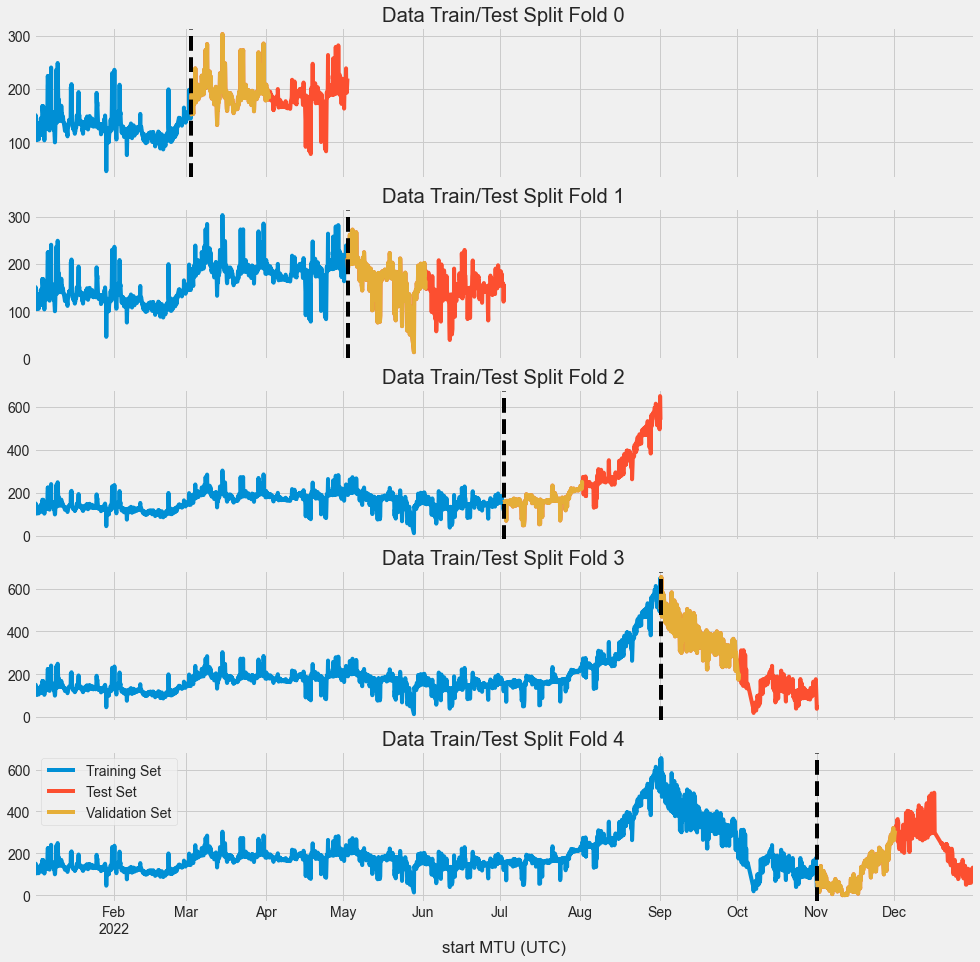

Runtime for training the model : 28.05 seconds 


In [88]:
times_series = TimeSeriesSplit(n_splits=5, gap=0)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
predictions = []

# start timer
start_time_training = time.time()
for train_idx, val_idx in times_series.split(df):
    train_data = df.iloc[train_idx]
    test = df.iloc[val_idx]
    val_data, test_data = train_test_split(test, test_size=0.5, shuffle=False)

    # Train dataset
    X_train = train_data[all_lagged_feature_names]
    y_train = train_data["Day-ahead Price _EUR/MWh_ BZN|NO1"]

    # Validation set, used for eval_set() method in the XGBoost library
    X_valid = val_data[all_lagged_feature_names]
    y_valid = val_data[TARGET]

    # Define the XGBoost regressor
    default_reg = xgb.XGBRegressor(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        nthread=4,
        eval_metric='rmse',
        seed=27
    )

    # Fit the model on the training data
    model = default_reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    # Test dataset, used for predicting
    X_test = test_data[all_lagged_feature_names]
    y_test = test_data[TARGET]


    train_data[TARGET].plot(ax=axs[fold],
                       label='Training Set')

    test[TARGET].plot(ax=axs[fold],
                      label='Test Set')

    val_data[TARGET].plot(ax=axs[fold],
                          label='Validation Set',
                          title=f'Data Train/Test Split Fold {fold}')

    axs[fold].axvline(test.index.min(), color='black', ls='--')

    fold += 1

plt.legend(loc="best")
plt.show()

end_time_training = time.time()
#print the run time
print("Runtime for training the model : {:.2f} seconds ".format(end_time_training - start_time_training))


### Evaluate the model on the training data.

In [89]:
from sklearn.metrics import mean_absolute_percentage_error
# start timer
start_time_testing= time.time()
# Calculate metrics on training data
y_train_pred = model.predict(X_train)
mape = mean_absolute_percentage_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)

print("RMSE:", rmse)
print("MAE:", mae)
print("MSE:", mse)
print("MAPE:", mape*100)


end_time_testing = time.time()
#print the run time
print("Runtime for predicting the test data: {:.2f} seconds ".format(end_time_testing - start_time_testing))

RMSE: 0.21529900933756543
MAE: 0.16525929289221067
MSE: 0.04635366342173709
MAPE: 0.10007274789679851
Runtime for predicting the test data: 0.06 seconds 


### Evaluate the model on the validation data.

In [90]:
from sklearn.metrics import mean_absolute_percentage_error
# start timer
start_time_testing= time.time()
# Calculate metrics on training data
y_valid_pred = model.predict(X_valid)
mape = mean_absolute_percentage_error(y_valid, y_valid_pred)
mae = mean_absolute_error(y_valid, y_valid_pred)
mse = mean_squared_error(y_valid, y_valid_pred)
rmse = np.sqrt(mse)

print("RMSE:", rmse)
print("MAE:", mae)
print("MSE:", mse)
print("MAPE:", mape*100)

end_time_testing = time.time()
#print the run time
print("Runtime for predicting the test data: {:.2f} seconds ".format(end_time_testing - start_time_testing))

RMSE: 9.131733904063484
MAE: 4.7488404076554005
MSE: 83.38856409462251
MAPE: 311.8709180184066
Runtime for predicting the test data: 0.01 seconds 


### Predict the test data

In [91]:
# Make predictions on the test data
predictions.append(model.predict(X_test))

# Flatten the predictions list
predictions = [item for sublist in predictions for item in sublist]

# Add the predicted values to the test_data DataFrame
test_data['prediction_test'] = predictions

### Evaluate the model on test data

In [110]:
# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, test_data['prediction_test']))
print(f'RMSE Score on test set: {rmse:0.2f}')

# Calculate the mean absolute error (MAE) between the predicted and actual values
mae_test_data = mean_absolute_error(y_test, test_data['prediction_test'])
print("Mean absolute error on test set: ", mae_test_data)

# Calculating the mean squared error (MSE) between the predicted and actual values
mse_test_data = mean_squared_error(y_test, test_data['prediction_test'])
print("Mean squared error on test set:", mse_test_data)

mape = mean_absolute_percentage_error(y_test, test_data['prediction_test'])
print("Mean absolute error on test set: ", mape * 100)

RMSE Score on test set: 12.53
Mean absolute error on test set:  8.20342322309316
Mean squared error on test set: 157.0791726989585
Mean absolute error on test set:  3.4980313157698957


### Plotting the predicted vs. actual values

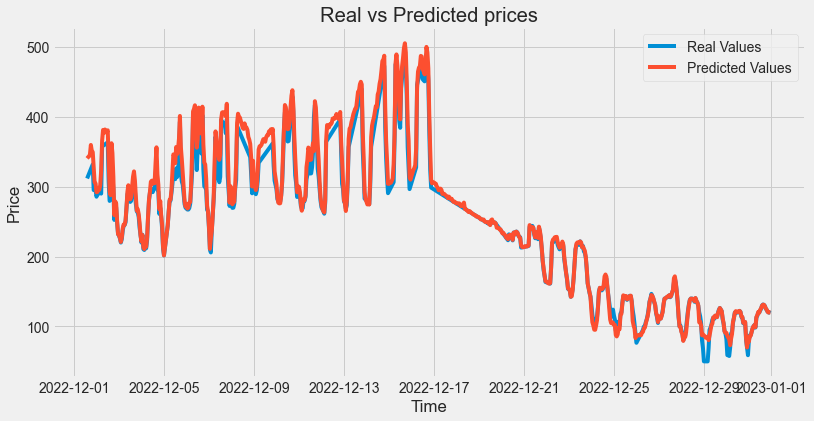

In [93]:
# Plotting predicted and real values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data[TARGET], label='Real Values')
plt.plot(test_data.index, predictions, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Real vs Predicted prices')
plt.legend()
plt.show()


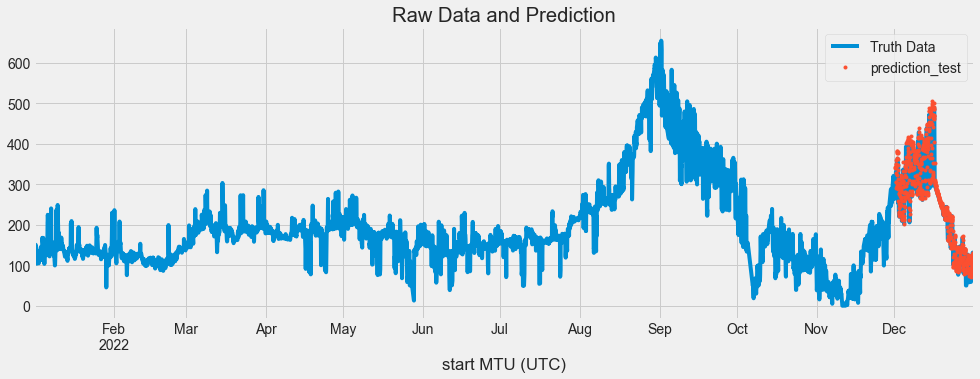

In [94]:
df = df.merge(test_data[['prediction_test']], how='left', left_index=True, right_index=True)
ax = df[['Day-ahead Price _EUR/MWh_ BZN|NO1']].plot(figsize=(15, 5))
df['prediction_test'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'prediction_test'])
ax.set_title('Raw Data and Prediction')
plt.show()

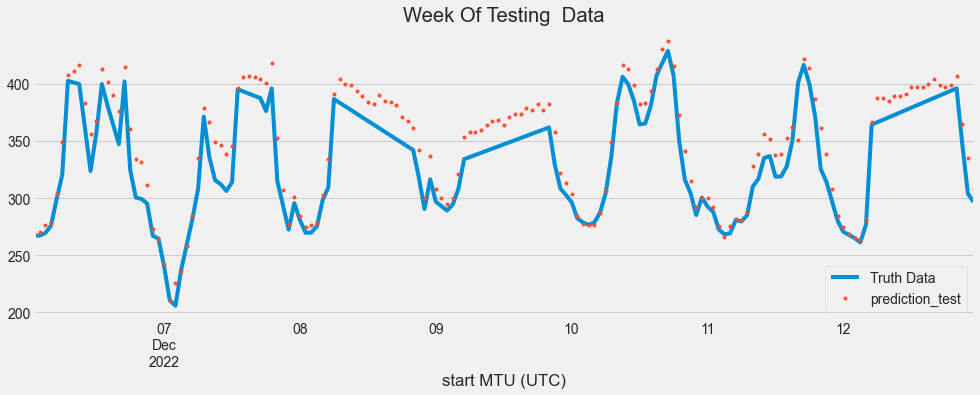

In [95]:
## Showing predicted test data on a week
ax = df.loc[(df.index > '2022-12-06') & (df.index < '2022-12-13')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Week Of Testing  Data')
df.loc[(df.index > '2022-12-06') & (df.index < '2022-12-13')]['prediction_test'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction_test'])
plt.show()

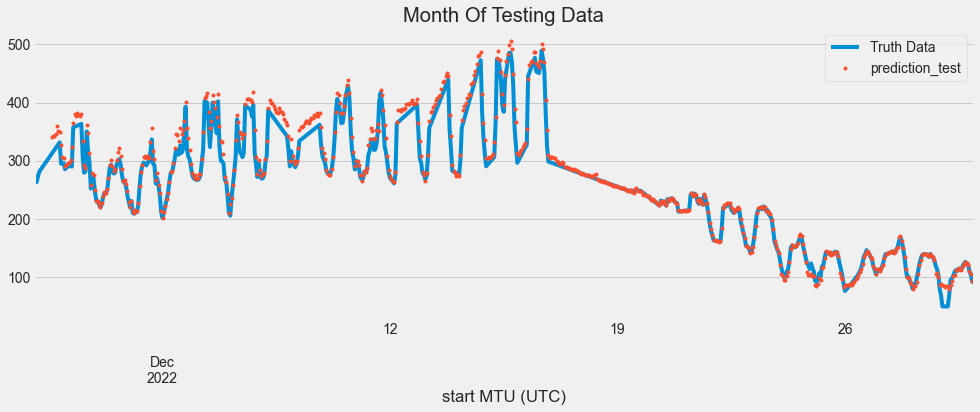

In [96]:
## Showing predicted test data on a week
ax = df.loc[(df.index > '2022-12-01') & (df.index < '2022-12-30')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Month Of Testing Data')
df.loc[(df.index > '2022-12-01') & (df.index < '2022-12-30')]['prediction_test'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction_test'])
plt.show()

### Determine if the RMSE value is a good fit

In [97]:
response_range_test_data = test['Day-ahead Price _EUR/MWh_ BZN|NO1'].max() - test['Day-ahead Price _EUR/MWh_ BZN|NO1'].min()

if rmse < 0.1 * response_range_test_data:
    print("The RMSE value of", rmse, "is a good fit for this time series regression model. When the response range is :", response_range_test_data)
else:
    print("The RMSE value of", rmse, "indicates poor performance for this time series regression model. When the response range is :", response_range_test_data)


The RMSE value of 12.533123022573363 is a good fit for this time series regression model. When the response range is : 489.31


# Calculate Error
- Look at the worst and best predicted days


In [98]:
test_data['error'] = np.abs(test_data[TARGET] - test_data['prediction_test'])
test_data['date'] = test_data.index.date
test_data.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-12-01    23.300835
2022-12-09    18.140376
2022-12-08    17.544406
2022-12-07    16.412830
2022-12-06    15.643837
2022-12-15    15.230121
2022-12-14    14.820914
2022-12-11    14.153755
2022-12-05    13.747370
2022-12-02    12.795731
Name: error, dtype: float64

### Simple regressor and parameters

# 6. Hyperparameter tuning

In [99]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500 , 700, 1000],  # Number of trees in the forest
    'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001],  # Learning rate
    'max_depth': [3, 4, 5, 6, 7],  # Maximum depth of each tree
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Subsample ratio of the training instances
    
     # Subsample ratio of columns when constructing each tree
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  
   
    
    # Minimum loss reduction required to make a further partition on a leaf node
    'gamma': [0, 0.05, 0.1, 0.15, 0.2],  
    
    'reg_alpha': [0, 0.05, 0.1, 0.3, 0.5],  # L1 regularization term on weights
    
    'reg_lambda': [0, 0.05, 0.1, 0.3, 0.5],  # L2 regularization term on weights
    
     # Minimum sum of instance weight (hessian) needed in a child
    'min_child_weight': [1, 2, 3, 4, 5],  
   
    # Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'reg_gamma': [0, 0.1, 0.2, 0.3, 0.4], 
    
}

# Define the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()


###  Random search

In [100]:
# start timer
start_time_random_serach = time.time()
# Perform random search
random_search = RandomizedSearchCV(
    xgb_regressor,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Scoring metric for evaluation
    cv=5,  # Number of cross-validation folds
    verbose=1,
    random_state=42
)

# Fit the model with random search
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

end_time_random_search = time.time()
#print the run time
print("Runtime for random search: {:.2f} seconds ".format(end_time_random_search - start_time_random_serach))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[19:58:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "reg_gamma" } are not used.

[19:58:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "reg_gamma" } are not used.

[19:58:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "reg_gamma" } are not used.

[19:58:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "reg_gamma" } are not used.

[19:58:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "reg_gamma" } are not used.

[19:58:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "reg_gamma" } are not used.

[19:59:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\sr

### Test the model on the test data again after HyperparameterTuning

In [101]:
# start timer
start_time_training_tuned_model_ = time.time()
# Define the XGBoost regressor
best_reg = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=700,
    max_depth= 6,
    gamma = 0.1,
    min_child_weight=4,
    reg_alpha = 0.5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='rmse',
    reg_lambda = 0.1,
)

# Append the train and validation data to the combined DataFrame, to train the tuned model.
combined_train_val_data = pd.DataFrame()  # Create an empty DataFrame
combined_train_val_data = combined_train_val_data.append(train_data)
combined_train_val_data = combined_train_val_data.append(val_data)

# Create X_combined_train_val_data and y_combined_train_val_data
X_combined_train_val_data = combined_train_val_data[all_lagged_feature_names]
y_combined_train_val_data = combined_train_val_data[TARGET]

# Fit the model on the training data
best_model = best_reg.fit(
    X_combined_train_val_data, y_combined_train_val_data,
    verbose= 100
)
print(best_model)

# Calculate metrics on training data
y_train_pred = best_model.predict(X_train)
mape = mean_absolute_percentage_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)

print("RMSE:", rmse)
print("MAE:", mae)
print("MSE:", mse)
print("MAPE:", mape*100)

end_time_training_tuned_model = time.time()
#print the run time
print("Runtime for training the tuned model on training + validation models combined: {:.2f} seconds".format(end_time_training_tuned_model - start_time_training_tuned_model_))

C:\Users\Isak\AppData\Local\Temp\ipykernel_51356\147770787.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_train_val_data = combined_train_val_data.append(train_data)
C:\Users\Isak\AppData\Local\Temp\ipykernel_51356\147770787.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_train_val_data = combined_train_val_data.append(val_data)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=700, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
RMSE: 0.18552021744364555
MAE: 0.13955145762810714
MSE: 0.03441775108033753
MAPE: 0.08620625927240494
Runtime for training the tuned model on training + validation models combined: 3.85 seconds


In [102]:
# start timer
start_time_testing_tuned_model = time.time()
predictions_after = [best_model.predict(X_test)]
# Flatten the predictions list
predictions_after = [item for sublist in predictions_after for item in sublist]
# Add the predicted values to the test_data DataFrame
test_data['prediction_test_after_tuning'] = predictions_after

end_time_testing_tuned_model = time.time()
#print the run time
print("Runtime for testing the tuned model om testing data: {:.2f} seconds".format(end_time_testing_tuned_model - start_time_testing_tuned_model))

Runtime for testing the tuned model om testing data: 0.01 seconds


In [113]:
rmse_after_tuning = np.sqrt(mean_squared_error(test_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], test_data['prediction_test_after_tuning']))
print(f'RMSE Score on test set: {rmse_after_tuning:0.2f}')

# Calculate the mean absolute error (MAE) between the predicted and actual values
mae_after_tuning = mean_absolute_error(test_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], test_data['prediction_test_after_tuning'])
print("Mean absolute error on test set: ", mae_after_tuning)

# Calculating the mean squared error (MSE) between the predicted and actual values
mse_after_tuning = mean_squared_error(test_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], test_data['prediction_test_after_tuning'])
print("Mean squared error on test set:", mse_after_tuning)
mape_test = mean_absolute_percentage_error(test_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], test_data['prediction_test'])
print("Mean absolute error on test set: ", mape_test*100)

RMSE Score on test set: 8.19
Mean absolute error on test set:  4.908055809022815
Mean squared error on test set: 67.13275699538491
Mean absolute error on test set:  3.4980313157698957


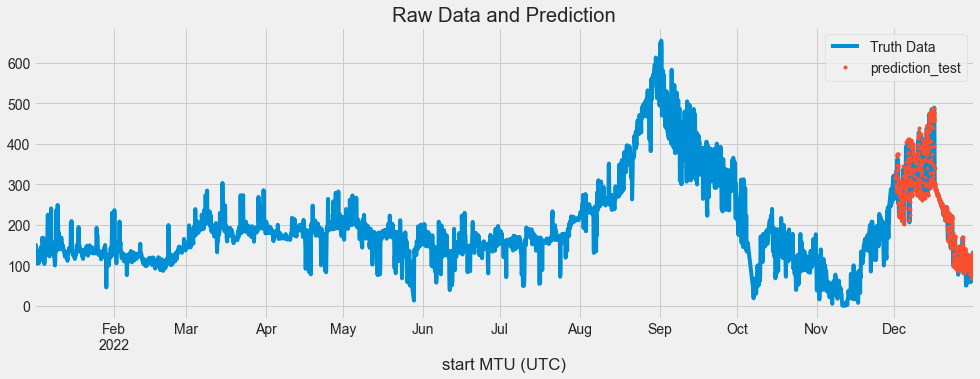

In [104]:
df = df.merge(test_data[['prediction_test_after_tuning']], how='left', left_index=True, right_index=True)
ax = df[['Day-ahead Price _EUR/MWh_ BZN|NO1']].plot(figsize=(15, 5))
df['prediction_test_after_tuning'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'prediction_test'])
ax.set_title('Raw Data and Prediction')
plt.show()

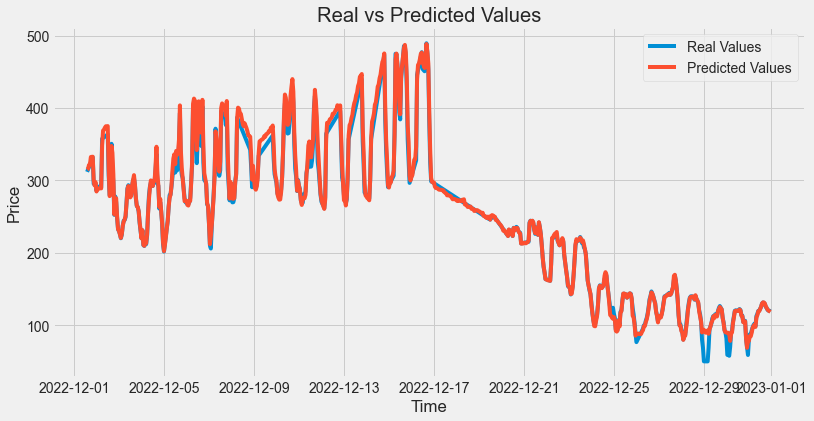

In [115]:
# Plotting predicted and real values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data[TARGET], label='Real Values')
plt.plot(test_data.index, predictions_after, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Real vs Predicted Values')
plt.legend()
plt.show()

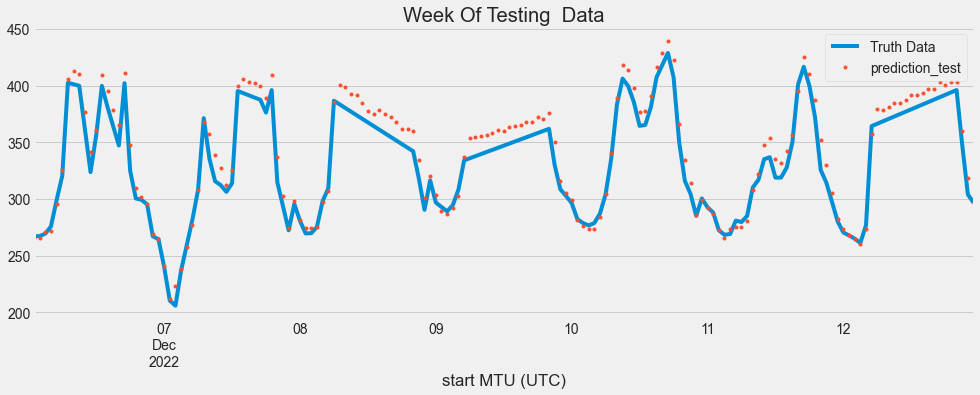

In [106]:
## Showing predicted test data on a week
ax = test_data.loc[(test_data.index > '2022-12-06') & (test_data.index < '2022-12-13')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Week Of Testing  Data')
test_data.loc[(test_data.index > '2022-12-06') & (test_data.index < '2022-12-13')]['prediction_test_after_tuning'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction_test'])
plt.show()

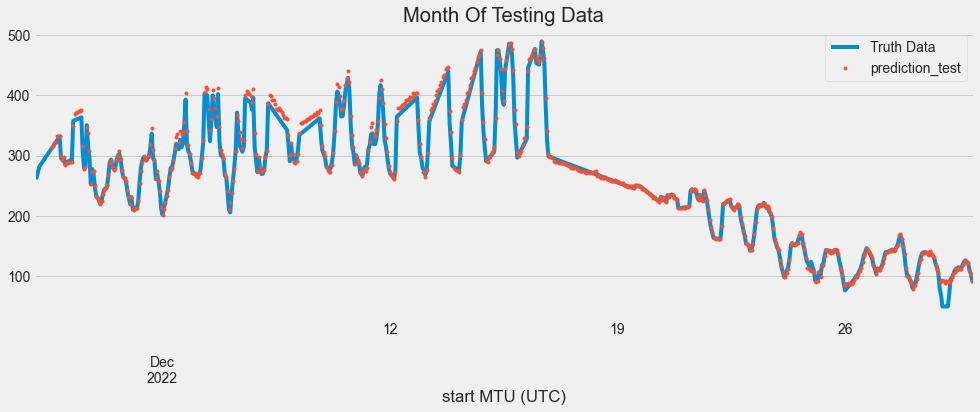

In [107]:
## Showing predicted test data on a month
ax = df.loc[(df.index > '2022-12-01') & (df.index < '2022-12-30')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Month Of Testing Data')
df.loc[(df.index > '2022-12-01') & (df.index < '2022-12-30')]['prediction_test_after_tuning'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction_test'])
plt.show()